## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer
import nltk
from nltk.corpus import stopwords
import re



## Loading data

In [2]:
# Columns to keep
columns = ['drugName', 'condition', 'review', 'rating', 'date', 'usefulCount']

df_train = pd.read_table("data/train.tsv", usecols=columns)
df_train

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37
...,...,...,...,...,...,...
161292,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10.0,"May 31, 2015",125
161293,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1.0,"November 1, 2011",34
161294,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2.0,"March 15, 2014",35
161295,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10.0,"September 19, 2015",79


In [3]:
df_test = pd.read_table("data/test.tsv", usecols=columns)
df_test

,drugName,condition,review,rating,date,usefulCount
0,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4
...,...,...,...,...,...,...
53761,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,"September 13, 2014",43
53762,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9.0,"October 8, 2016",11
53763,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8.0,"November 15, 2010",7
53764,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1.0,"November 28, 2011",20


## Data Cleaning

In [4]:
print("Shape of training set :" ,df_train.shape)
print("Shape of the test set :", df_test.shape)


Shape of training set : (161297, 6)
Shape of the test set : (53766, 6)


In [5]:
#check if there is any
df_train.isnull().any()


drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
dtype: bool

In [6]:
df_test.isnull().any()


drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
dtype: bool

In [7]:
df_train.isnull().sum()

drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [8]:
df_test.isnull().sum()

drugName         0
condition      295
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [9]:
df_train['condition'].head(10)

0    Left Ventricular Dysfunction
1                            ADHD
2                   Birth Control
3                   Birth Control
4               Opiate Dependence
5    Benign Prostatic Hyperplasia
6         Emergency Contraception
7                 Bipolar Disorde
8                        Epilepsy
9                   Birth Control
Name: condition, dtype: object

replace the missing values of the condition with unknown, since we don't know the name of the condition, we will keep it as unknown. 

In [10]:
# df_train['condition'] = df_train['condition'].fillna('unknown')
# df_test['condition'] = df_test['condition'].fillna('unknown')

In [11]:
df_train.isnull().sum()

drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [12]:
df_test.isnull().sum()

drugName         0
condition      295
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   drugName     161297 non-null  object 
 1   condition    160398 non-null  object 
 2   review       161297 non-null  object 
 3   rating       161297 non-null  float64
 4   date         161297 non-null  object 
 5   usefulCount  161297 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 7.4+ MB


In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   drugName     53766 non-null  object 
 1   condition    53471 non-null  object 
 2   review       53766 non-null  object 
 3   rating       53766 non-null  float64
 4   date         53766 non-null  object 
 5   usefulCount  53766 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 2.5+ MB


In [15]:
df_test.describe()

,rating,usefulCount
count,53766.000000,53766.000000
mean,6.976900,27.989752
std,3.285207,36.172833
min,1.000000,0.000000
25%,4.000000,6.000000
50%,8.000000,16.000000
75%,10.000000,36.000000
max,10.000000,949.000000


In [16]:
merge = [df_train,df_test]
merged_data = pd.concat(merge,ignore_index=True)

merged_data.shape   #check the shape of merged_data

(215063, 6)

In [17]:
merged_data.isnull().sum()

drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64

In [18]:
merged_data.dropna(inplace=True, axis=0)

In [19]:
merged_data.isnull().sum()

drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [20]:
#Let's check the number of drugs/condition
merged_data.groupby('condition')['drugName'].nunique().sort_values(ascending=False).head(20)

condition
Not Listed / Othe                             253
Pain                                          219
Birth Control                                 181
High Blood Pressure                           146
Acne                                          127
Depression                                    115
Rheumatoid Arthritis                          107
Diabetes, Type 2                               97
Allergic Rhinitis                              95
Insomnia                                       85
Osteoarthritis                                 84
Bipolar Disorde                                82
Anxiety                                        81
Abnormal Uterine Bleeding                      77
Endometriosis                                  64
3</span> users found this comment helpful.     62
Psoriasis                                      61
Migraine                                       60
ADHD                                           58
4</span> users found this comment helpfu

In [21]:
# let's check the span
span_data = merged_data[merged_data['condition'].str.contains('</span>',case=False,regex=True) == True]
print('Number of rows with </span> values : ', len(span_data))
noisy_data_ = 100 * (len(span_data)/merged_data.shape[0])
print('Total percent of noisy data {} %  '.format(noisy_data_))

Number of rows with </span> values :  1171
Total percent of noisy data 0.5475314327929715 %  


In [22]:
merged_data.drop(span_data.index, axis = 0, inplace=True)

In [23]:
# Check the percentage of 'not listed / othe' conditions
not_listed = merged_data[merged_data['condition'].str.contains('not listed / othe',case=False,regex=True) == True] 
print('Number of not_listed values : ', len(not_listed))
percent_not_listed = 100 * len(not_listed)/merged_data.shape[0]
print('Total percent of noisy data :  {} %  '.format(percent_not_listed))

Number of not_listed values :  592
Total percent of noisy data :  0.2783288982501011 %  


In [24]:
# Drop noisy data
merged_data.drop(not_listed.index, axis = 0, inplace=True)

In [25]:
#convert the date to datetime
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data['date'] = pd.to_datetime(merged_data['date'])

In [26]:
merged_data['review'] = merged_data['review'].str.replace('[^a-zA-Z0-9\s]', '').str.lower()

/var/folders/px/sn54g8qd5sn8l01t5511xfs40000gn/T/ipykernel_77862/237122813.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  merged_data['review'] = merged_data['review'].str.replace('[^a-zA-Z0-9\s]', '').str.lower()


In [27]:
merged_data['drugName'] = merged_data['drugName'].str.strip()
merged_data['condition'] = merged_data['condition'].str.strip()

In [28]:
merged_data.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,it has no side effect i take it in combination...,9.0,2012-05-20,27
1,Guanfacine,ADHD,my son is halfway through his fourth week of i...,8.0,2010-04-27,192
2,Lybrel,Birth Control,i used to take another oral contraceptive whic...,5.0,2009-12-14,17
3,Ortho Evra,Birth Control,this is my first time using any form of birth ...,8.0,2015-11-03,10
4,Buprenorphine / naloxone,Opiate Dependence,suboxone has completely turned my life around ...,9.0,2016-11-27,37


In [29]:
# check one review from a customer, and see.
merged_data['review'][3]

'this is my first time using any form of birth control i039m glad i went with the patch i have been on it for 8 months at first it decreased my libido but that subsided the only downside is that it made my periods longer 56 days to be exact i used to only have periods for 34 days max also made my cramps intense for the first two days of my period i never had cramps before using birth control other than that in happy with the patch'

## EDA

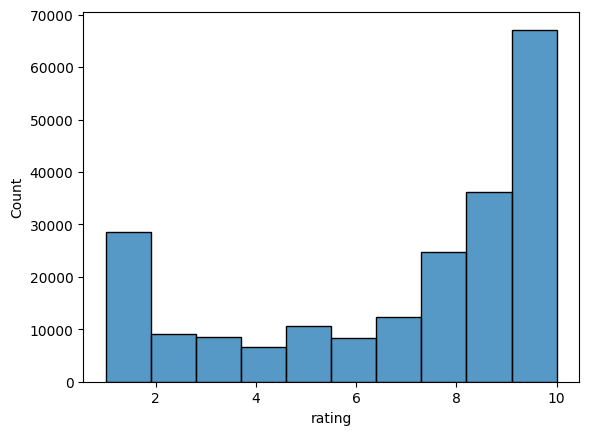

In [30]:
# plot and understand the distribution of the rating 
sns.histplot(merged_data['rating'], bins=10)
plt.show()

Levonorgestrel                        4890
Etonogestrel                          4402
Ethinyl estradiol / norethindrone     3612
Nexplanon                             2883
Ethinyl estradiol / norgestimate      2679
Ethinyl estradiol / levonorgestrel    2397
Phentermine                           2046
Sertraline                            1855
Escitalopram                          1734
Mirena                                1647
Implanon                              1496
Gabapentin                            1399
Bupropion                             1355
Miconazole                            1341
Venlafaxine                           1327
Citalopram                            1301
Medroxyprogesterone                   1271
Duloxetine                            1246
Lexapro                               1242
Bupropion / naltrexone                1241
Name: drugName, dtype: int64


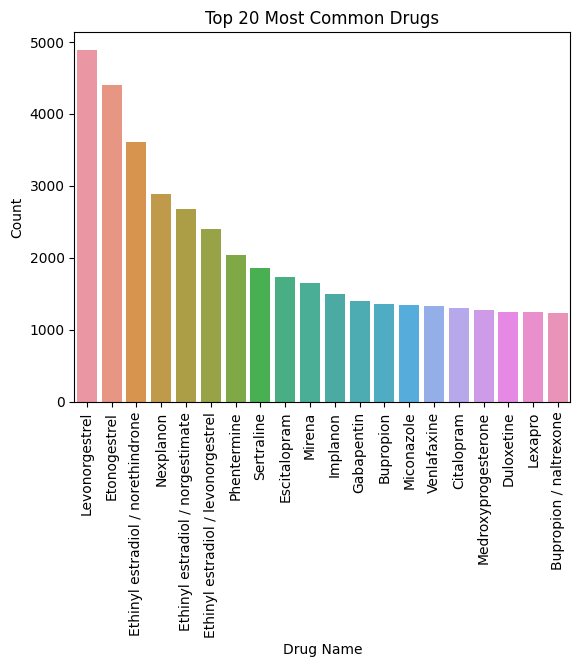

In [31]:
# Bar plot of top N most common drug names
n = 20 
top_drugs = merged_data['drugName'].value_counts().head(n)
print(top_drugs)
sns.barplot(x=top_drugs.index, y=top_drugs.values)
plt.xlabel('Drug Name')
plt.ylabel('Count')
plt.title(f'Top {n} Most Common Drugs')
plt.xticks(rotation=90)
plt.show()

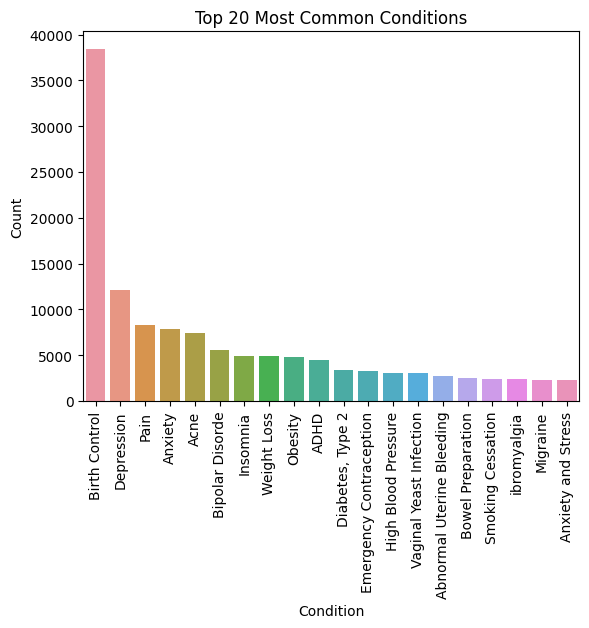

In [32]:
# Bar plot of top N most common conditions
n = 20  
top_conditions = merged_data['condition'].value_counts().head(n)
sns.barplot(x=top_conditions.index, y=top_conditions.values)
plt.xlabel('Condition')
plt.ylabel('Count')
plt.title(f'Top {n} Most Common Conditions')
plt.xticks(rotation=90)
plt.show()

This bar graph displays the top 10 medical conditions that are prevalent among people based on the given dataset. The most common condition by a significant margin is Birth Control, followed by Depression and Pain.

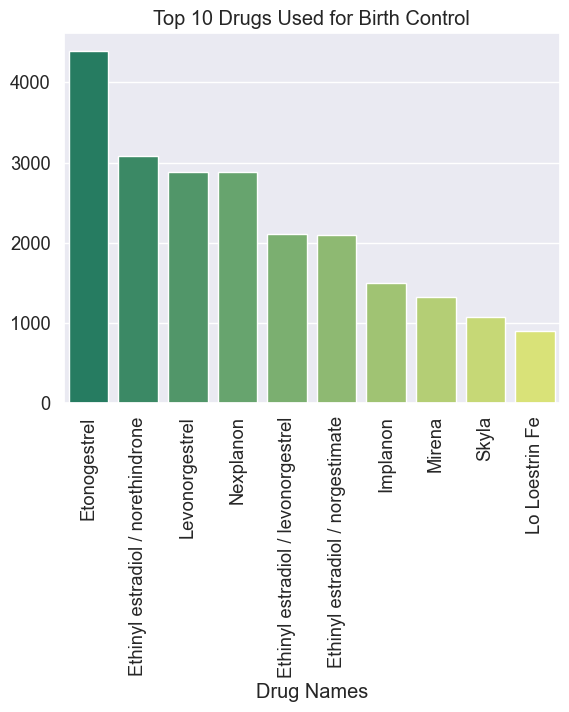

In [33]:
# The subset of the Birth Control condition and count the occurrence of each drug
subset_df = merged_data[merged_data['condition'] == 'Birth Control']

drug_counts = subset_df['drugName'].value_counts().head(10)
sns.set(font_scale=1.2, style='darkgrid')
sns_plot = sns.barplot(x=drug_counts.index, y=drug_counts.values, palette='summer')
sns_plot.set_xlabel('Drug Names')
sns_plot.set_title('Top 10 Drugs Used for Birth Control')
plt.setp(sns_plot.get_xticklabels(), rotation=90)
plt.show()

This bar graph above displays the top 10 drugs used by people with Birth Control as their condition. Etonogestrel is the most widely used drug for this condition by a significant margin based on the dataset.

/var/folders/px/sn54g8qd5sn8l01t5511xfs40000gn/T/ipykernel_77862/1804018870.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = merged_data.corr()


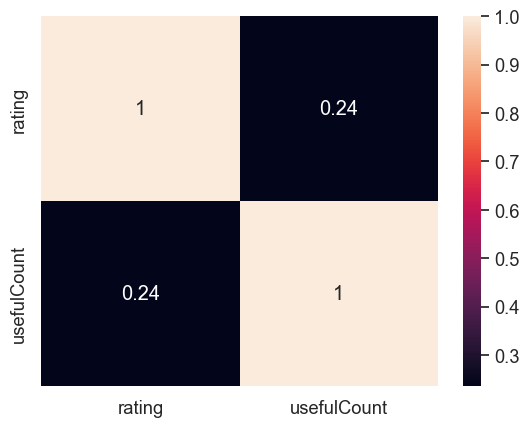

In [34]:
# the correlation of the data
corr_matrix = merged_data.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [35]:
# Creating a new column 'Review_Sentiment' based on rating
merged_data['r_sentiment'] = np.where(merged_data['rating']>=5, 1, 0)

# Counting the values of the new column
sentiment_counts = merged_data['r_sentiment'].value_counts()

# Printing the value counts
print("Review Sentiment Distribution:")
print(sentiment_counts)

Review Sentiment Distribution:
1    159244
0     52862
Name: r_sentiment, dtype: int64


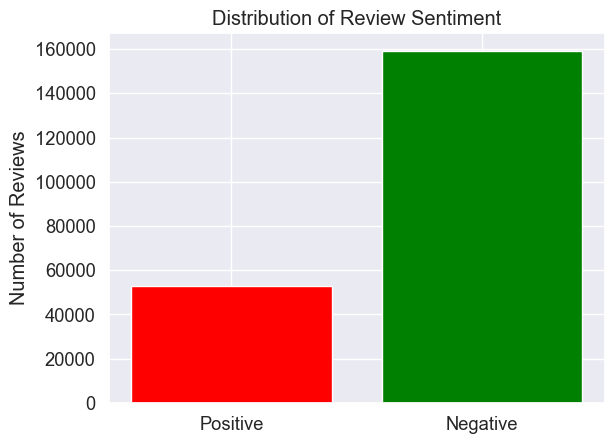

In [36]:
sentiment_counts = merged_data['r_sentiment'].value_counts()

plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red'])
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.ylabel('Number of Reviews')
plt.title('Distribution of Review Sentiment')
plt.show()

The bar chart above depicts the distribution of sentiment among reviewers, indicating that negative reviews are more prevalent than positive reviews.

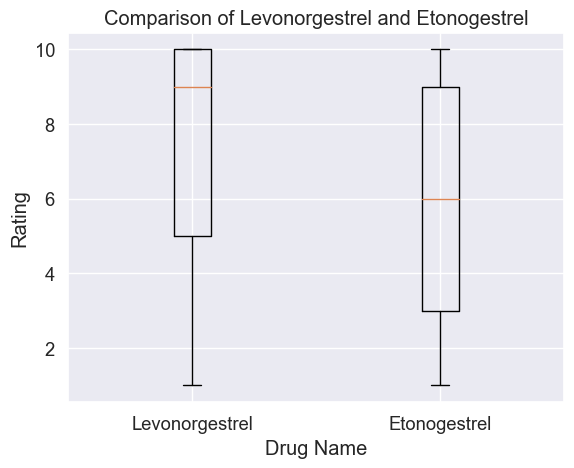

In [37]:
# Filter the data for Ortho Evra and Lybrel
df_comparison = merged_data[(merged_data['drugName'] == 'Levonorgestrel') | (merged_data['drugName'] == 'Etonogestrel')]

# Plot the ratings for each drug
plt.boxplot([df_comparison[df_comparison['drugName'] == 'Levonorgestrel']['rating'], df_comparison[df_comparison['drugName'] == 'Etonogestrel']['rating']])
plt.title("Comparison of Levonorgestrel and Etonogestrel")
plt.xlabel("Drug Name")
plt.ylabel("Rating")
plt.xticks([1, 2], ['Levonorgestrel', 'Etonogestrel'])
plt.show()

/var/folders/px/sn54g8qd5sn8l01t5511xfs40000gn/T/ipykernel_77862/2147673452.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_data['month'] = pd.to_datetime(bc_data['date']).dt.month_name()


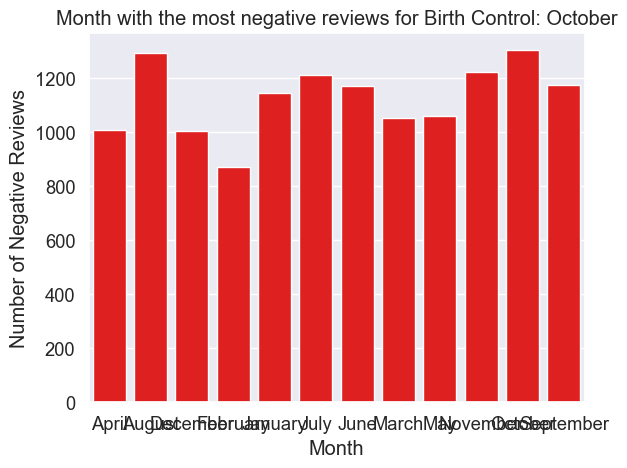

In [38]:
# Create a subset of the data for the birth control condition
bc_data = merged_data[merged_data['condition'] == 'Birth Control']

# Create a new column for the month
bc_data['month'] = pd.to_datetime(bc_data['date']).dt.month_name()

# Group the data by month and count the number of negative reviews
neg_reviews = bc_data[bc_data['rating'] < 5].groupby('month').size().reset_index(name='count')

# Find the month with the highest count
top_month = neg_reviews.loc[neg_reviews['count'].idxmax(), 'month']

# Plot the result
sns.barplot(x='month', y='count', data=neg_reviews, color='red')
plt.title(f"Month with the most negative reviews for Birth Control: {top_month}")
plt.xlabel("Month")
plt.ylabel("Number of Negative Reviews")
plt.show()

The total number most negative reviews for bitrh control by month.

The bar chart that shows the top 10 drugs and conditions with the most reviews, both negative and positive. The bars are colored based on the condition, and the legend shows which color corresponds to which condition.

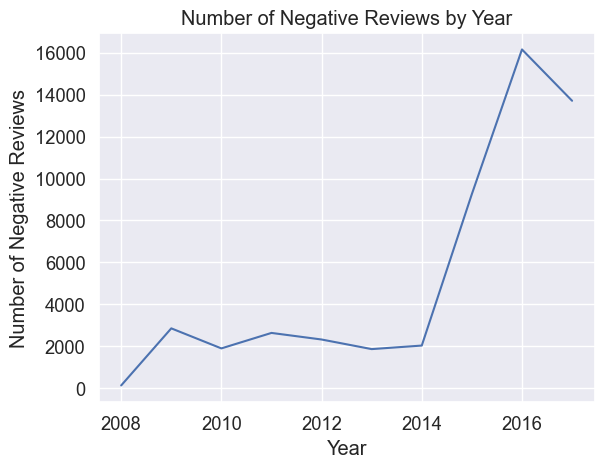

In [39]:
merged_data['year'] = merged_data['date'].dt.year

# Group the data by year and count the number of negative reviews in each year
yearly_negative_reviews = merged_data[merged_data['r_sentiment'] == 0].groupby('year').size()

# Plot the results
plt.plot(yearly_negative_reviews.index, yearly_negative_reviews.values)
plt.title('Number of Negative Reviews by Year')
plt.xlabel('Year')
plt.ylabel('Number of Negative Reviews')
plt.show()

Number of the the negative review for every year starting from 2008 to 2016, and this plot showing the number of the negative reviews are increasing year by year.  

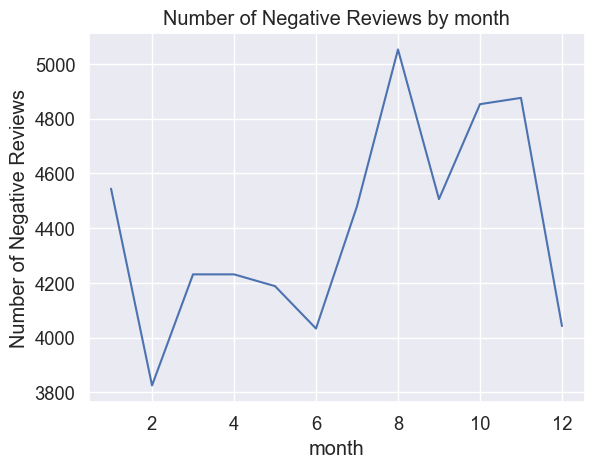

In [40]:
# Create a new column 'year' to extract the year from the date
merged_data['month'] = merged_data['date'].dt.month

# Group the data by year and count the number of negative reviews in each year
yearly_negative_reviews = merged_data[merged_data['r_sentiment'] == 0].groupby('month').size()

# Plot the results
plt.plot(yearly_negative_reviews.index, yearly_negative_reviews.values)
plt.title('Number of Negative Reviews by month')
plt.xlabel('month')
plt.ylabel('Number of Negative Reviews')
plt.show()

Number of the the negative review for every month, to see in which month the customer has the most negative reviews

## Pre-processing 

In [41]:
#check first three reviews
for i in merged_data['review'][0:3]:
    print(i,'\n')

it has no side effect i take it in combination of bystolic 5 mg and fish oil 

my son is halfway through his fourth week of intuniv we became concerned when he began this last week when he started taking the highest dose he will be on for two days he could hardly get out of bed was very cranky and slept for nearly 8 hours on a drive home from school vacation very unusual for him i called his doctor on monday morning and she said to stick it out a few days see how he did at school and with getting up in the morning the last two days have been problem free he is much more agreeable than ever he is less emotional a good thing less cranky he is remembering all the things he should overall his behavior is better 
we have tried many different medications and so far this is the most effective 

i used to take another oral contraceptive which had 21 pill cycle and was very happy very light periods max 5 days no other side effects but it contained hormone gestodene which is not available in us 

/var/folders/px/sn54g8qd5sn8l01t5511xfs40000gn/T/ipykernel_77862/1181111665.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for i in merged_data['review'][0:3]:


Steps for reviews pre-processing

1. Remove HTML tags
2. Remove Stop Words
3. Remove symbols and special characters
4. Tokenize
5. Stemming


In [52]:
stops = set(stopwords.words('english')) #english stopwords

stemmer = SnowballStemmer('english') #SnowballStemmer

In [53]:
def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))

In [56]:
def review_clean(review):
    # Convert to lower case
    review = review.apply(lambda x: x.lower())

    # Replace repeating pattern of '&#039;'
    review = review.apply(lambda x: x.replace("&#039;", ""))

    # Remove all special characters
    review = review.str.replace('[^a-zA-Z0-9\s]', '')

    # Remove all non-ASCII characters
    review = review.apply(lambda x: ''.join([i if ord(i) < 128 else '' for i in x]))

    # Remove leading and trailing whitespaces
    review = review.str.strip()

    # Replace multiple spaces with single space
    review = review.str.replace('\s+', ' ')

    # Replace two or more dots with one
    review = review.str.replace('\.{2,}', '.')

    return review


In [57]:
merged_data['clean_review'] = review_clean(merged_data['review']).apply(review_to_words)

/var/folders/px/sn54g8qd5sn8l01t5511xfs40000gn/T/ipykernel_77862/3247578144.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  review = review.str.replace('[^a-zA-Z0-9\s]', '')
/var/folders/px/sn54g8qd5sn8l01t5511xfs40000gn/T/ipykernel_77862/3247578144.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  review = review.str.replace('\s+', ' ')
/var/folders/px/sn54g8qd5sn8l01t5511xfs40000gn/T/ipykernel_77862/3247578144.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  review = review.str.replace('\.{2,}', '.')


In [58]:
merged_data['clean_review'][0:20]


/var/folders/px/sn54g8qd5sn8l01t5511xfs40000gn/T/ipykernel_77862/669818286.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  merged_data['clean_review'][0:20]


0            side effect take combin bystol mg fish oil
1     son halfway fourth week intuniv becam concern ...
2     use take anoth oral contracept pill cycl happi...
3     first time use form birth control glad went pa...
4     suboxon complet turn life around feel healthie...
5     nd day mg start work rock hard erect howev exp...
6     pull cum bit took plan b hour later took pregn...
7     abilifi chang life hope zoloft clonidin first ...
8     noth problem keppera constant shake arm amp le...
9     pill mani year doctor chang rx chateal effect ...
10    medic almost two week start mg work way mg cur...
11    taken antidepress year improv most moder sever...
12    crohn resect year ago most remiss sinc recent ...
13    littl bit linger cough cold give much troubl e...
14    start nexplanon month ago minim amount contrac...
15    take saxenda sinc juli sever nausea month got ...
16    drug work well clear uti matter hrs although d...
17    take amitriptylin sinc januari diagnos fib

In [59]:
merged_data.head()

,drugName,condition,review,rating,date,usefulCount,r_sentiment,year,month,clean_review
0,Valsartan,Left Ventricular Dysfunction,it has no side effect i take it in combination...,9.0,2012-05-20,27,1,2012,5,side effect take combin bystol mg fish oil
1,Guanfacine,ADHD,my son is halfway through his fourth week of i...,8.0,2010-04-27,192,1,2010,4,son halfway fourth week intuniv becam concern ...
2,Lybrel,Birth Control,i used to take another oral contraceptive whic...,5.0,2009-12-14,17,1,2009,12,use take anoth oral contracept pill cycl happi...
3,Ortho Evra,Birth Control,this is my first time using any form of birth ...,8.0,2015-11-03,10,1,2015,11,first time use form birth control glad went pa...
4,Buprenorphine / naloxone,Opiate Dependence,suboxone has completely turned my life around ...,9.0,2016-11-27,37,1,2016,11,suboxon complet turn life around feel healthie...


In [60]:
# Creates TF-IDF vectorizer and transforms the corpus
vectorizer = TfidfVectorizer()
reviews_tf = vectorizer.fit_transform(merged_data.clean_review)
reviews_tf.shape

(212106, 60683)

In [61]:
r_sentiment = merged_data.r_sentiment

In [62]:
X_train,X_test,Y_train,Y_test = train_test_split(reviews_tf ,r_sentiment,test_size=0.33,random_state=42)
print('Train data shape ',X_train.shape,Y_train.shape)
print('Test data shape ',X_test.shape,Y_test.shape)

Train data shape  (142111, 60683) (142111,)
Test data shape  (69995, 60683) (69995,)


In [515]:
def modeling(X, y):
    """
    Fit multiple models and save the weights
    
    Parameters:
    X (pd.DataFrame): Features
    y (pd.Series): Labels
    
    Returns:
    None
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # Fit and save the models
    models = {
        'Naive Bayes': MultinomialNB(max_iter=1000).fit(X_train, y_train),
        'Random Forest': RandomForestClassifier(max_iter=1000).fit(X_train, y_train),
        'LogisticRegression': LogisticRegression(max_iter=1000).fit(X_train, y_train)
        # Add more models here
    }
    
    # Save the models
    for model_name, model in models.items():
        with open(f"{model_name}.pkl", "wb") as f:
            pickle.dump(model, f)


In [517]:
def predictions(X, y):
    """
    Load the saved models and make predictions
    
    Parameters:
    X (pd.DataFrame): Features
    y (pd.Series): Labels
    
    Returns:
    None
    """
    # Load the models
    models = {}
    for model_name in ['Naive Bayes', 'Random Forest', 'LogisticRegression']:
        with open(f"{model_name}.pkl", "rb") as f:
            models[model_name] = pickle.load(f)

    # Make predictions
    preds = {}
    for model_name, model in models.items():
        preds[model_name] = model.predict(X)
        print(f"{model_name} Accuracy: {accuracy_score(y, preds[model_name])}")
        print(f"{model_name} Confusion Matrix:\n{confusion_matrix(y, preds[model_name])}\n")

    # Plot the confusion matrices
    for model_name in preds:
        cm = confusion_matrix(y, preds[model_name])
        ax = plt.subplot()
        sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.set_title(f"{model_name} Confusion Matrix")
        plt.show()

In [519]:
modeling(X_train, Y_train)

/Users/mahamatnour/.virtualenvs/cv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Naive Bayes Accuracy: 0.7578255589684978
Naive Bayes Confusion Matrix:
[[  528 16899]
 [   52 52516]]

Random Forest Accuracy: 0.8655903993142368
Random Forest Confusion Matrix:
[[ 8262  9165]
 [  243 52325]]

LogisticRegression Accuracy: 0.8450460747196228
LogisticRegression Confusion Matrix:
[[ 9558  7869]
 [ 2977 49591]]



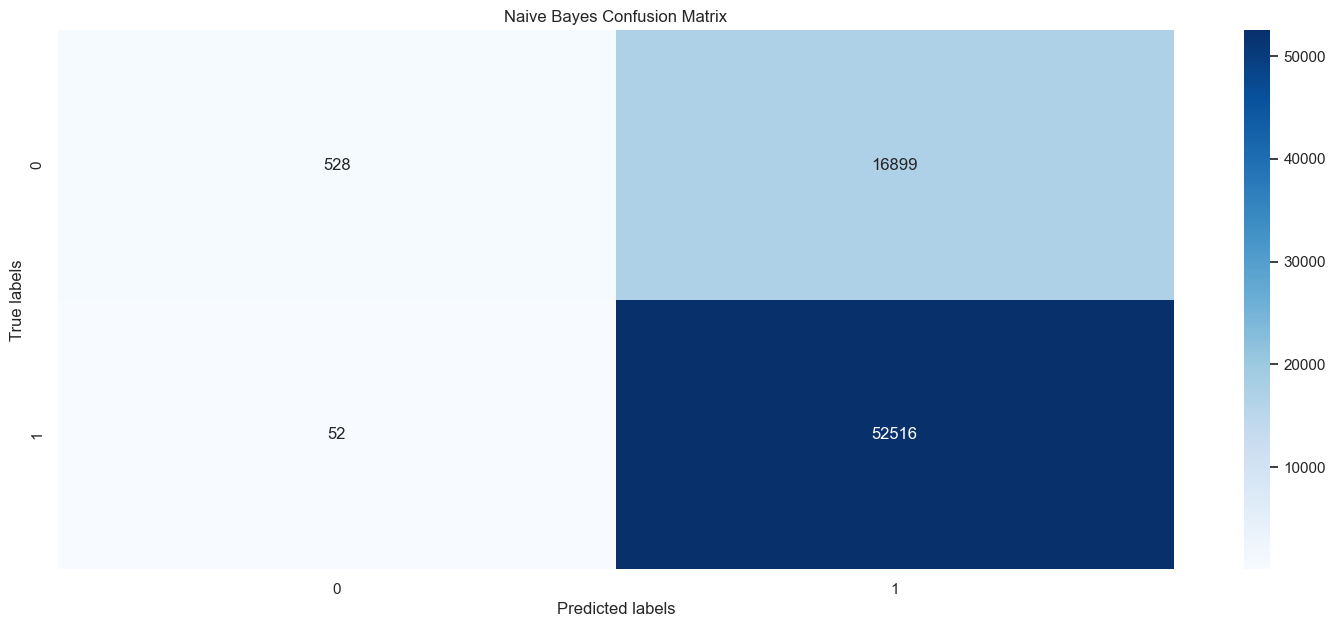

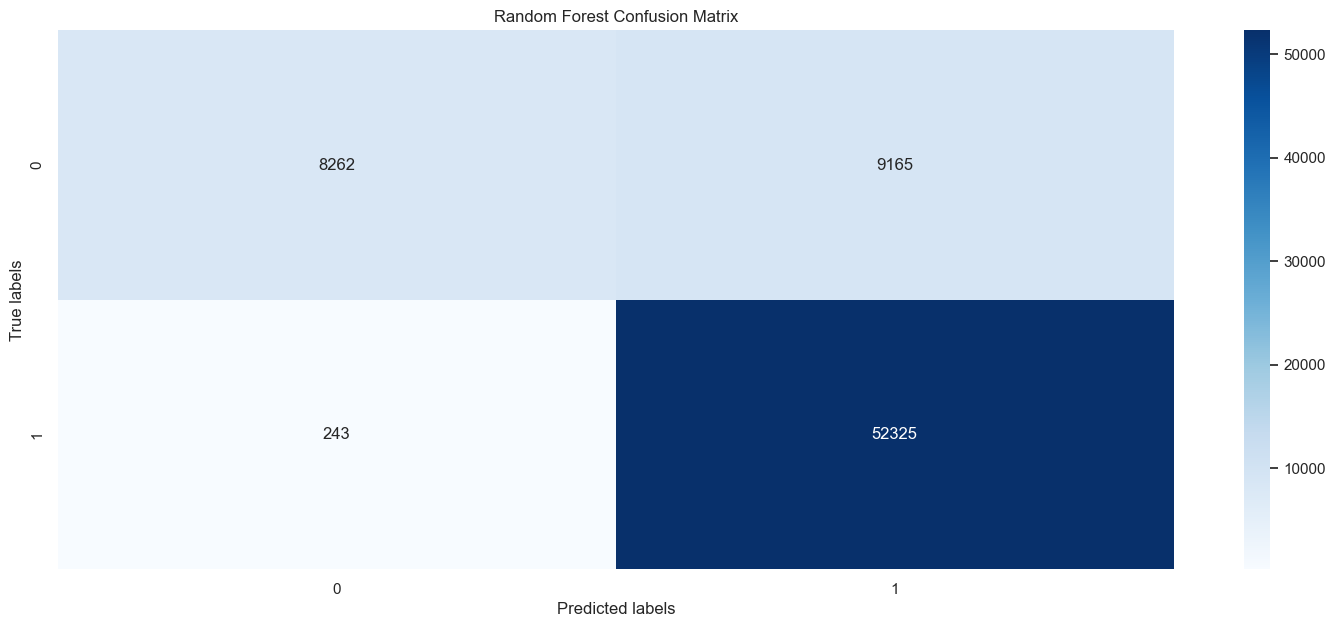

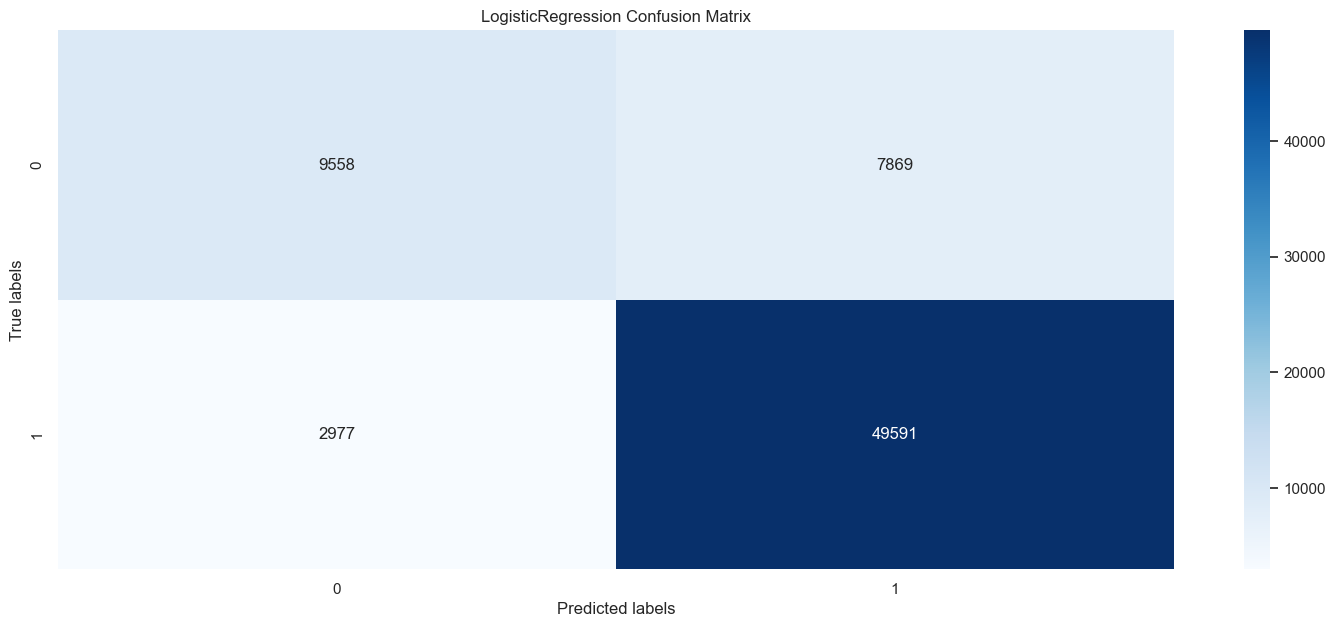

In [520]:
predictions(X_test, Y_test)

The Random Forest model achieved the highest accuracy of 0.865, followed by the Logistic Regression model with an accuracy of 0.845, and finally the Naive Bayes model with an accuracy of 0.758.

Looking at the confusion matrices, it appears that the Random Forest model has the lowest number of false positives (9165) and false negatives (243), which suggests that it is better at correctly predicting positive and negative reviews.

Overall, it seems that the Random Forest model is the best performing model for this task.

In [521]:
vectorizer = CountVectorizer()

# Transform the corpus
reviews_bow = vectorizer.fit_transform(merged_data.clean_review)
reviews_bow.shape

(212106, 60683)

In [522]:
X_train_bow,X_test_bow,Y_train_bow,Y_test_bow = train_test_split(reviews_bow ,r_sentiment,test_size=0.33,random_state=42)
print('Train data shape ',X_train_bow.shape,Y_train_bow.shape)
print('Test data shape ',X_test_bow.shape,Y_test.shape)

Train data shape  (142111, 60683) (142111,)
Test data shape  (69995, 60683) (69995,)


In [523]:
modeling(X_train_bow, Y_train_bow)

/Users/mahamatnour/.virtualenvs/cv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Naive Bayes Accuracy: 0.8164868919208514
Naive Bayes Confusion Matrix:
[[10342  7085]
 [ 5760 46808]]

Random Forest Accuracy: 0.8691192228016287
Random Forest Confusion Matrix:
[[ 8622  8805]
 [  356 52212]]

LogisticRegression Accuracy: 0.8426601900135724
LogisticRegression Confusion Matrix:
[[10042  7385]
 [ 3628 48940]]



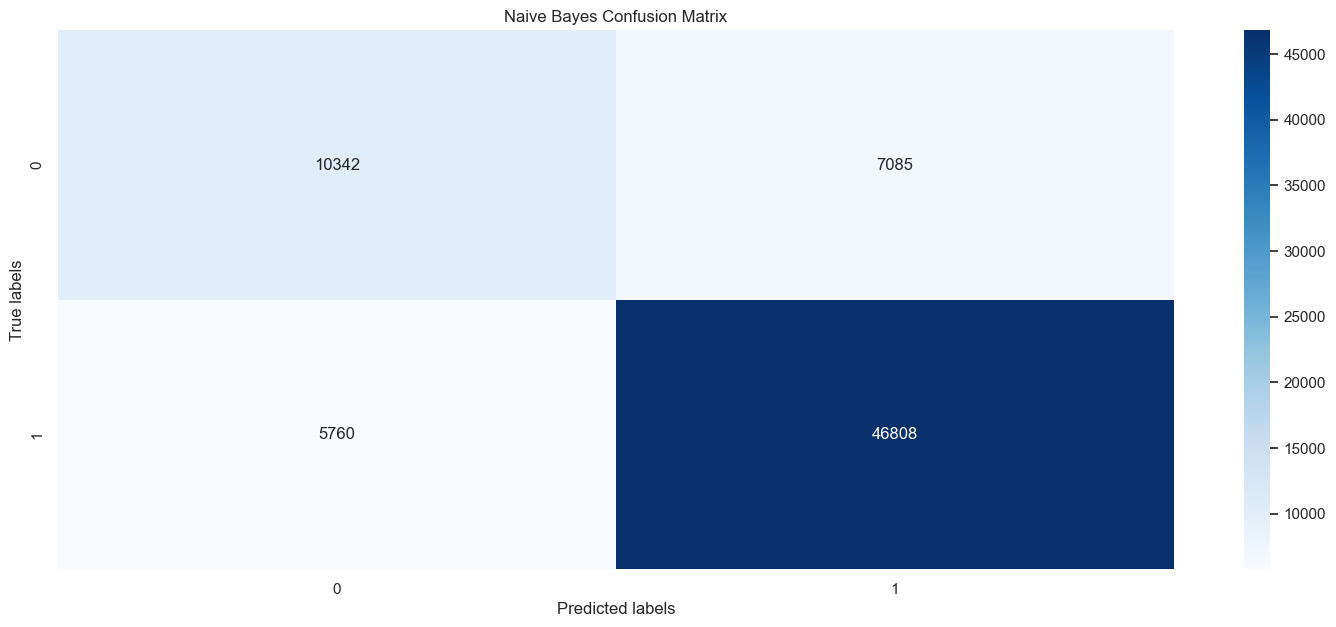

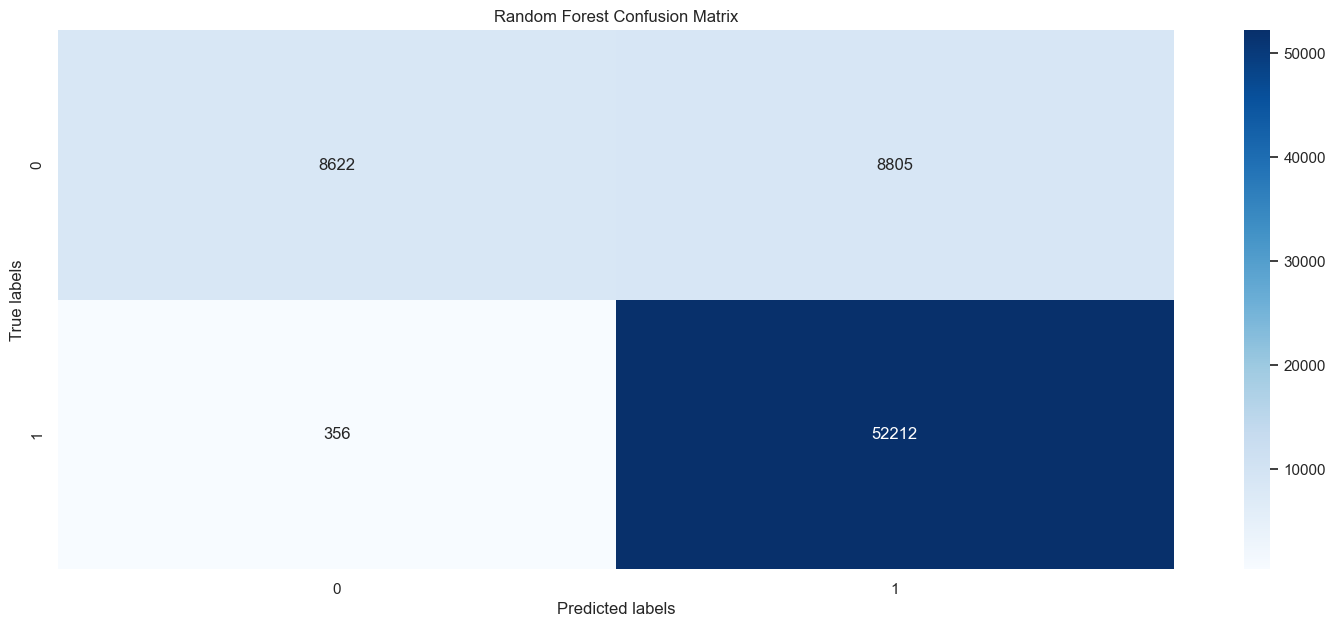

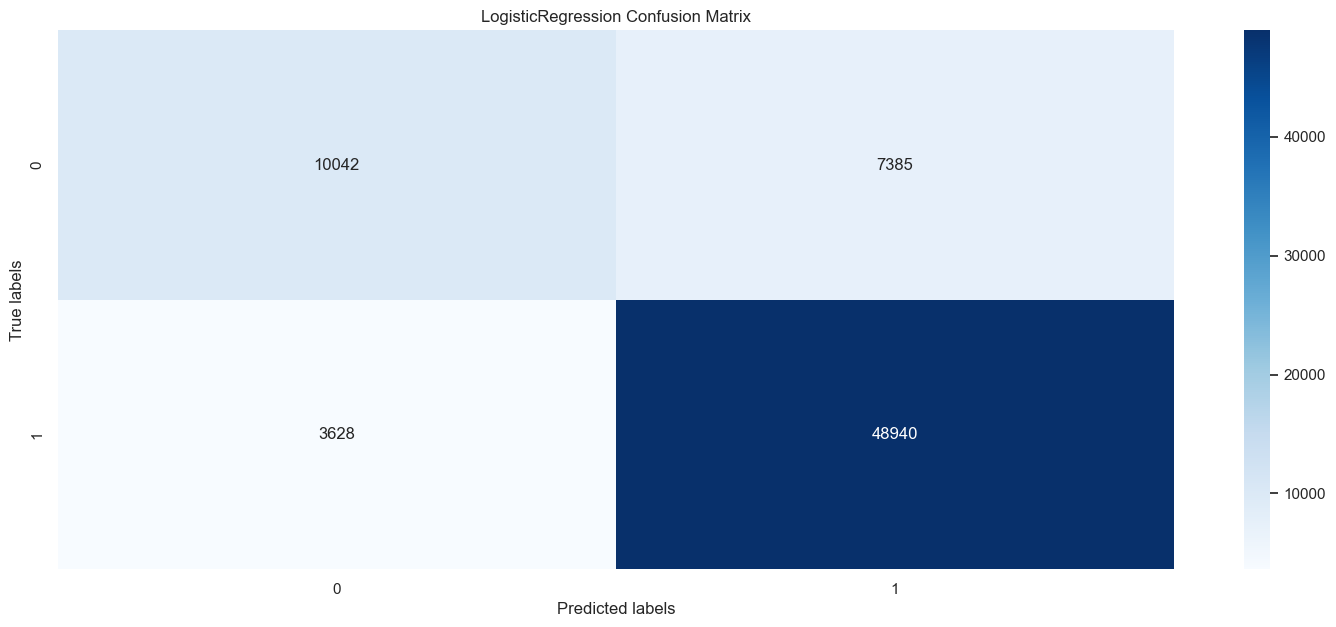

In [524]:
predictions(X_test_bow, Y_test_bow)

It looks like the Random Forest model performs similarly well with both TF-IDF and bag of words, but the Naive Bayes and Logistic Regression models perform better with TF-IDF. This could be because TF-IDF takes into account the rarity of certain words in the corpus, which may be more important for sentiment analysis than simply the frequency of words (as in bag of words). Similarly, word embeddings may also capture the semantic meaning of words in a way that can improve sentiment analysis. It's always worth trying out different approaches and comparing the results to see what works best for a specific task.

## Conclusion

To sum up, this notebook contain a short overview of data cleaning, EDA and modeling.